### Aggiunta Librerie

In [92]:
import datetime as datetime
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt

In [93]:
start_date = datetime.datetime(1998, 11, 1)
end_date = datetime.datetime.now()

start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

### Scraping dati

In [234]:
# Prendo i ticker che mi interessano

# leggo il file csv con i ticker
df = pd.read_csv("sp500_tickers.csv")
tickers_wanted = df["Ticker"].tolist()

# prendo solo i primi 5 tickers
#tickers_wanted = tickers_wanted[:100]

tickers_wanted = ["AAPL", "MSFT", "AMZN", "JPM", "WMT"]

In [235]:
# Scarico i dati dei tickers

# Setta questa variabile a True se vuoi scaricare i dati anche se già presenti
force_download = False
tickers = []
for ticker in tickers_wanted:
    try:
        #controllo se il file già esiste e in caso lo salto
        if f"{ticker}.csv" in os.listdir("stocks") and not force_download:
            print(f"{ticker} già scaricato")
            tickers.append(ticker)
            continue
        data = yf.download(ticker, start=start_date_str, end=end_date_str, period="1d")
        data.columns = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]
        if data.empty:
            print(f"{ticker} non ha dati")
            continue
        data.to_csv(f"stocks/{ticker}.csv")
        tickers.append(ticker)
    except Exception as e:
        print(f"Errore durante il download di {ticker}: {e}")


AAPL già scaricato
MSFT già scaricato
AMZN già scaricato
JPM già scaricato
WMT già scaricato


In [236]:
# Prendo i csv i li metto in una lista di dataframe
stocks = {}
for ticker in tickers:
    try:
        df = pd.read_csv(f"stocks/{ticker}.csv")
        stocks[ticker] = df
    except Exception as e:
        print(f"Errore durante la lettura di {ticker}: {e}")

## Tassi di rendimento

In [237]:
# Funzione per graficare i tassi di rendimento
def plot_ret_rate(df, title):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df, label='Return')
    plt.title(title, fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Return", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim()
    plt.ylim(-0.2, 0.2)
    plt.legend()
    plt.tight_layout()

    # Mostra il grafico
    plt.show()

### Tassi di rendimenti logaritmici giornalieri

In [238]:
# calcolo i rendimenti logaritmici giornalieri per tutte le stocks a partire dai prezzi di chiusura e li metto in un' altra lista di dataframe
log_daily_ret_rates = pd.DataFrame()
for ticker, stock in stocks.items():
    ret = pd.DataFrame()
    ret["Date"] = pd.to_datetime(stock["Date"].shift(-1)[:-1])
    p_t = stock["Adj Close"].shift(-1)[:-1]
    p_t_1 = stock["Adj Close"][:-1] 
    ret[ticker] = np.log(p_t / p_t_1)
    ret.set_index("Date", inplace=True)
    log_daily_ret_rates = pd.concat([log_daily_ret_rates, ret[ticker]], axis=1)
    
print(log_daily_ret_rates)


                               AAPL      MSFT      AMZN       JPM       WMT
1998-11-03 00:00:00+00:00  0.004971 -0.005924 -0.038420 -0.004435 -0.028561
1998-11-04 00:00:00+00:00  0.022876  0.002967  0.029313  0.030637  0.017601
1998-11-05 00:00:00+00:00 -0.013008  0.008259 -0.010163  0.040132  0.031633
1998-11-06 00:00:00+00:00 -0.003278  0.027240 -0.031121  0.010299  0.016763
1998-11-09 00:00:00+00:00 -0.038499  0.012500  0.018395 -0.045058 -0.012324
...                             ...       ...       ...       ...       ...
2024-11-14 00:00:00+00:00  0.013677  0.003967 -0.012313  0.002940 -0.012120
2024-11-15 00:00:00+00:00 -0.014210 -0.028248 -0.042847  0.014122 -0.002608
2024-11-18 00:00:00+00:00  0.013333  0.001830 -0.004502 -0.001142 -0.002020
2024-11-19 00:00:00+00:00  0.001140  0.004871  0.014324 -0.007949  0.029531
2024-11-20 00:00:00+00:00  0.003149 -0.005520 -0.008491 -0.009548  0.006675

[6555 rows x 5 columns]


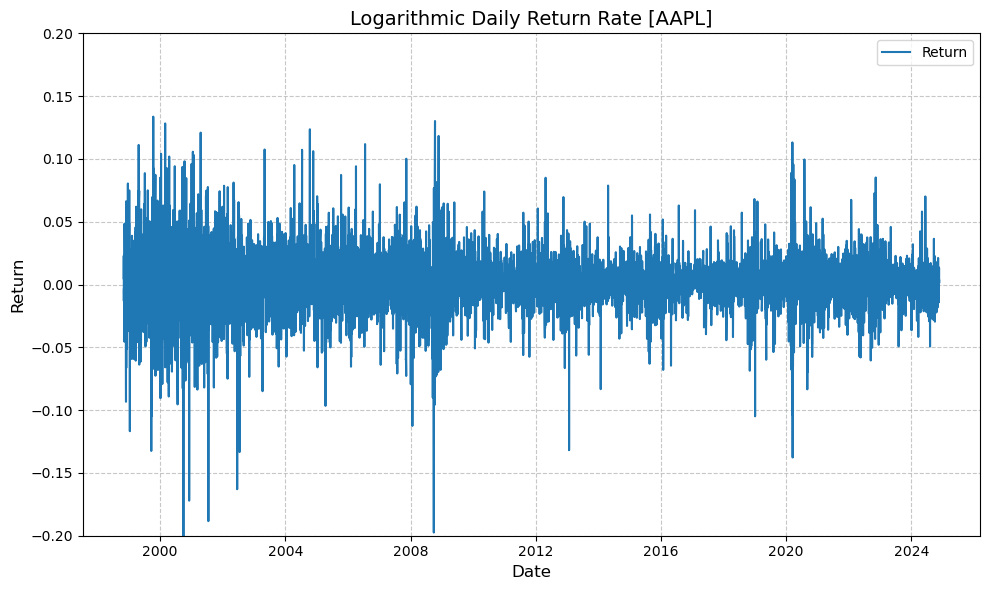

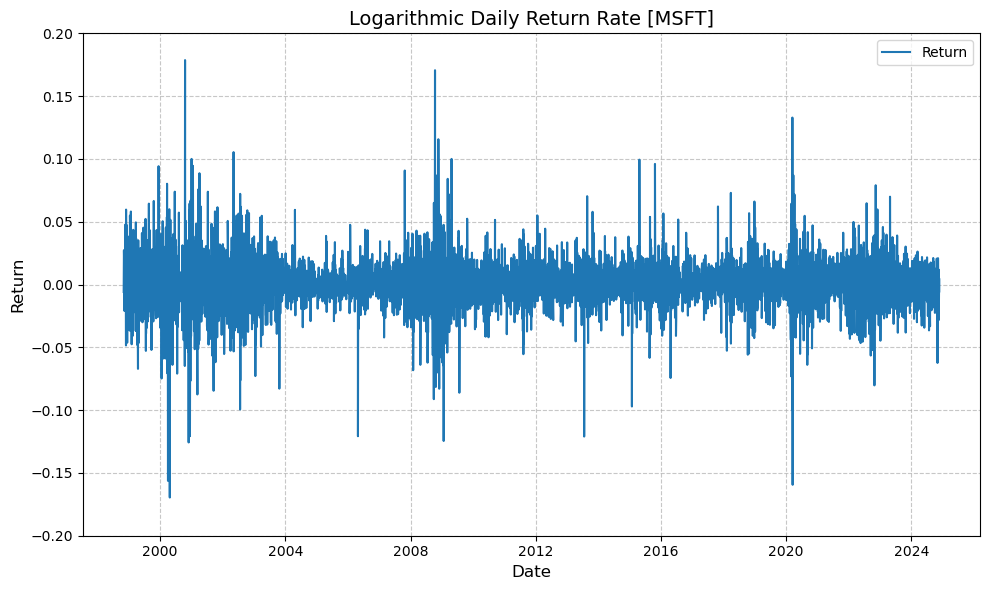

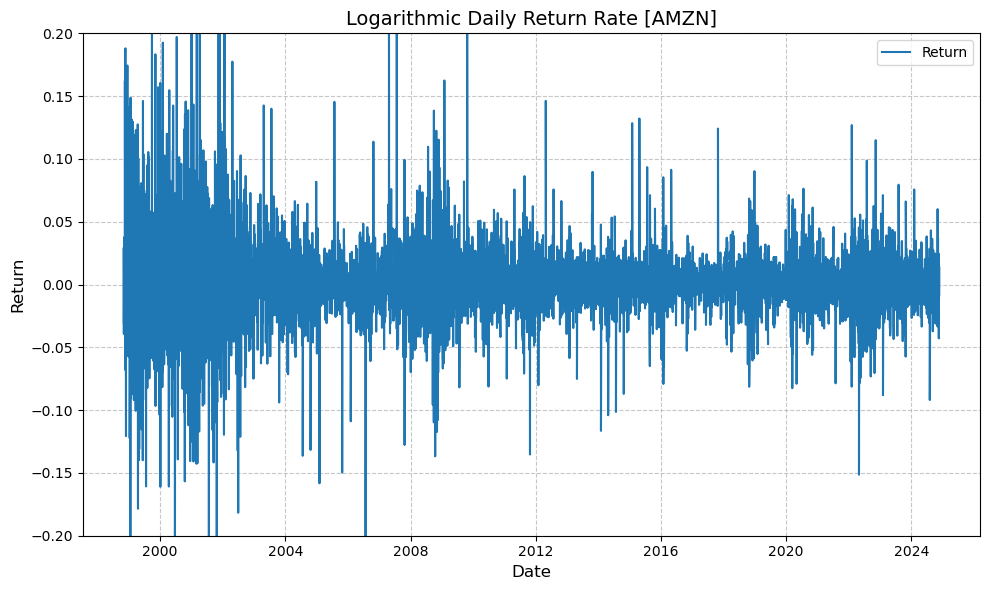

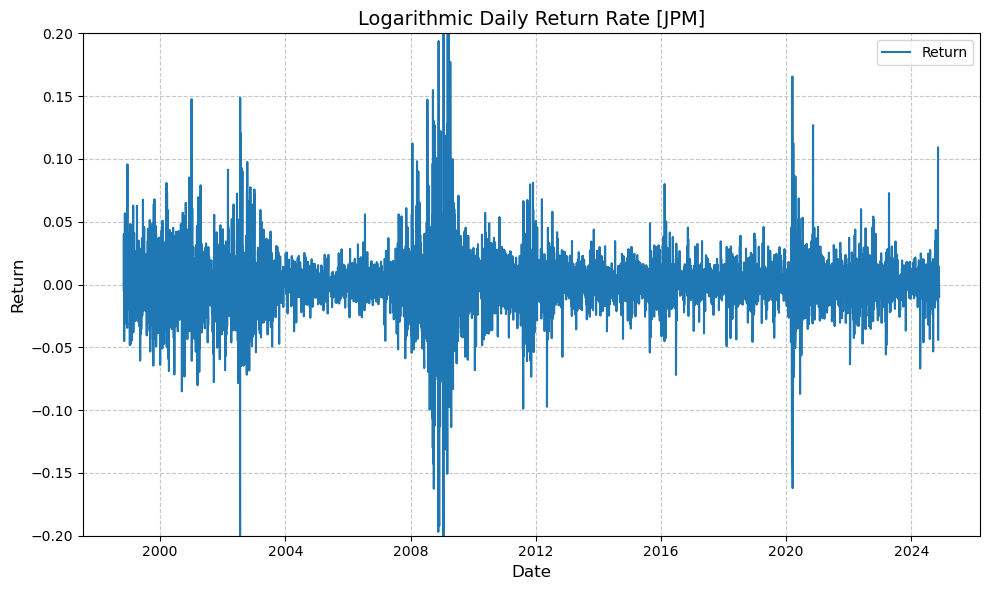

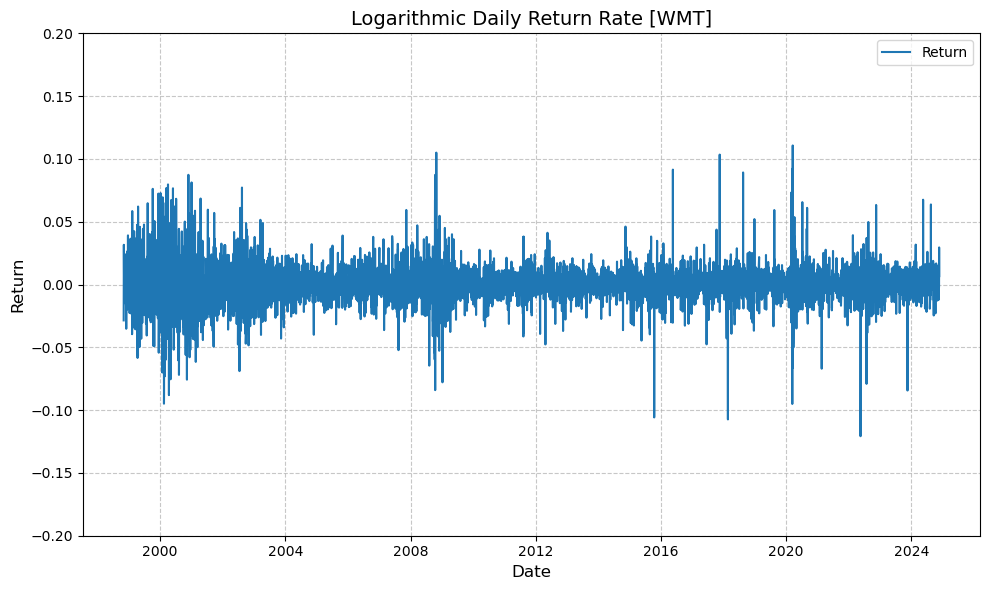

In [239]:
# Faccio il grafico di tutti i ritorni per ogni stock

for ticker in tickers:
    plot_ret_rate(log_daily_ret_rates[ticker], "Logarithmic Daily Return Rate [" + ticker + "]")

### Tassi di rendimento settimanali

In [240]:
weekly_ret_rates = pd.DataFrame()
for ticker, stock in stocks.items():
    ret = pd.DataFrame()
    ret["Date"] = pd.to_datetime(stock["Date"].shift(-1)[:-1])
    ret["Date"] = ret["Date"].dt.tz_localize(None)
    ret["Week"] = ret["Date"].dt.to_period("W")
    ret = ret.groupby("Week").first().reset_index()
    p_t = stock["Adj Close"].shift(-1)[:-1]
    p_t_1 = stock["Adj Close"][:-1] 
    ret[ticker] = (p_t - p_t_1)/p_t_1
    ret.set_index("Date", inplace=True)
    weekly_ret_rates = pd.concat([weekly_ret_rates, ret[ticker]], axis=1)
weekly_ret_rates.to_csv("weekly_ret_rates.csv")
print(weekly_ret_rates)

                         AAPL      MSFT      AMZN       JPM       WMT
1998-11-03 00:00:00  0.004983 -0.005907 -0.037691 -0.004425 -0.028157
1998-11-09 00:00:00  0.023139  0.002972  0.029747  0.031111  0.017757
1998-11-16 00:00:00 -0.012924  0.008293 -0.010111  0.040948  0.032139
1998-11-23 00:00:00 -0.003273  0.027615 -0.030642  0.010352  0.016904
1998-11-30 00:00:00 -0.037767  0.012578  0.018565 -0.044058 -0.012248
...                       ...       ...       ...       ...       ...
2024-10-21 00:00:00  0.006328 -0.006352 -0.006906 -0.006024 -0.006854
2024-10-28 00:00:00  0.032175  0.011187  0.025420  0.019636  0.012119
2024-11-04 00:00:00  0.000357 -0.004346  0.024322 -0.001902 -0.002162
2024-11-11 00:00:00 -0.031518 -0.010714 -0.011872 -0.000714 -0.005167
2024-11-18 00:00:00  0.002589  0.006016  0.033734  0.007390 -0.022449

[1360 rows x 5 columns]


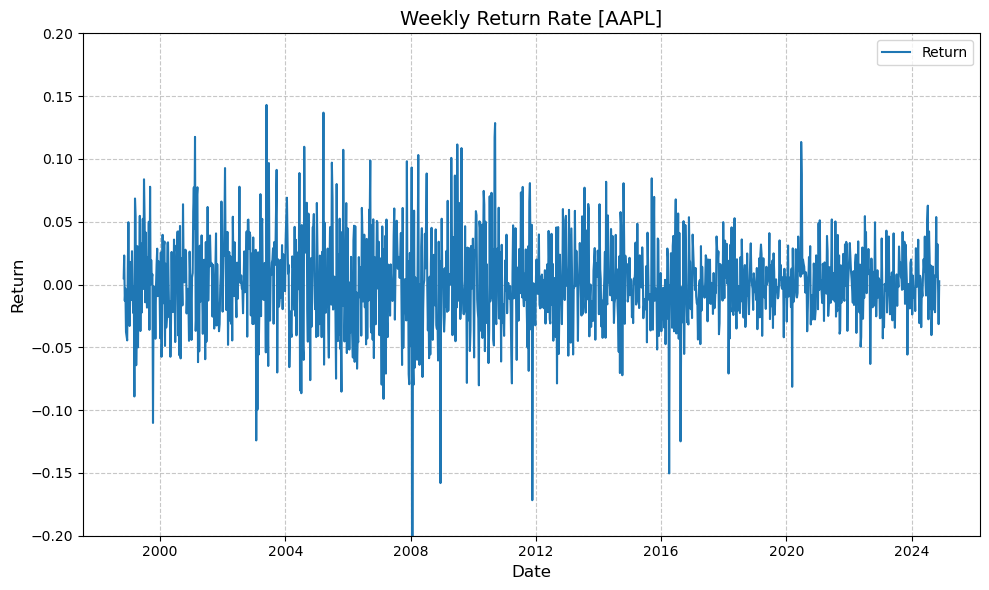

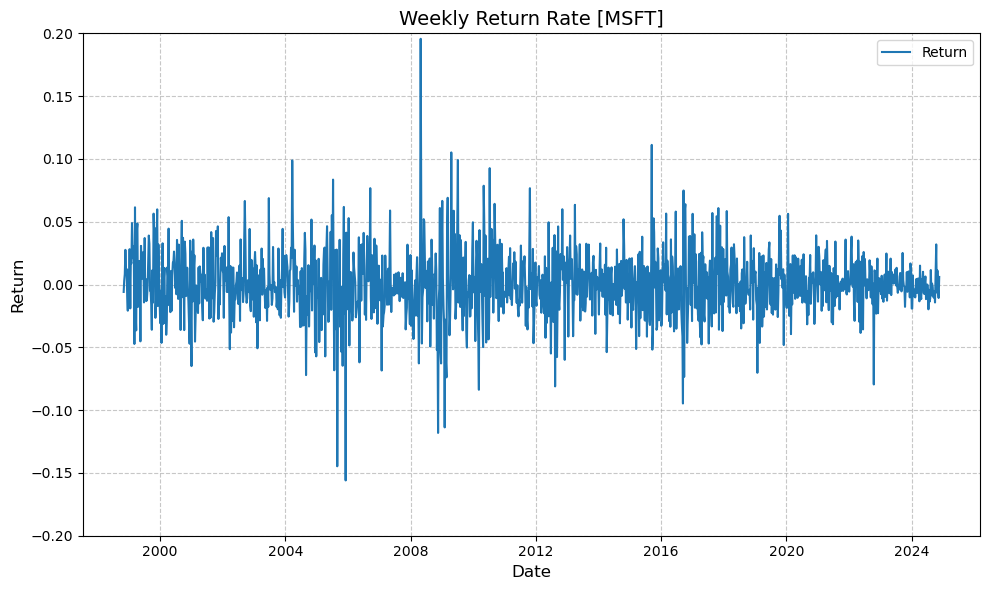

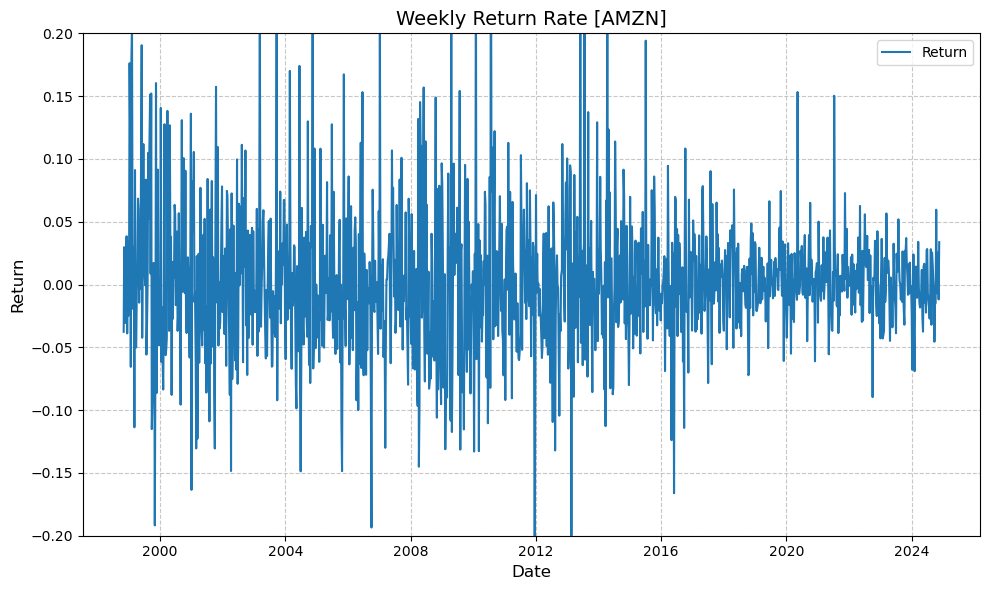

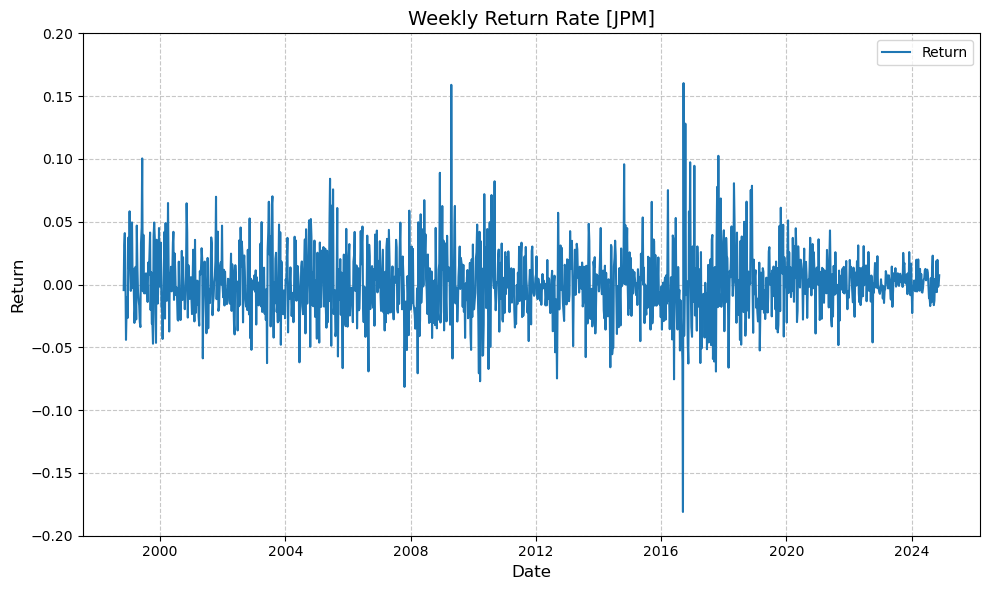

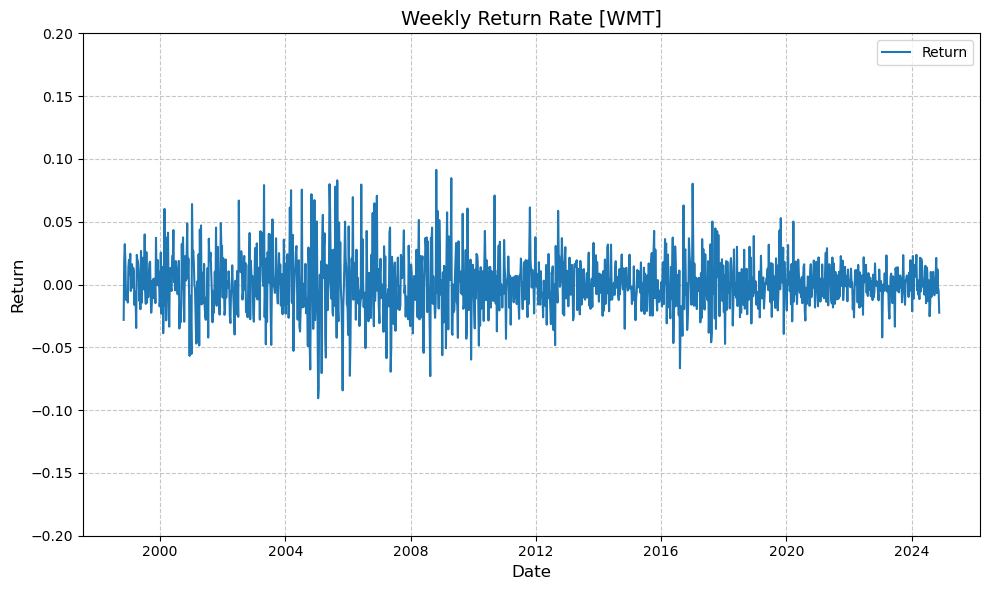

In [241]:
# Faccio il grafico di tutti i ritorni per ogni stock
for ticker in tickers:
    plot_ret_rate(weekly_ret_rates[ticker], "Weekly Return Rate [" + ticker + "]")

### Tassi di rendimento mensili

In [242]:
monthly_ret_rates = pd.DataFrame()
for ticker, stock in stocks.items():
    ret = pd.DataFrame()
    ret["Date"] = pd.to_datetime(stock["Date"].shift(-1)[:-1])
    ret["Date"] = ret["Date"].dt.tz_localize(None)
    ret["Month"] = ret["Date"].dt.to_period("M")
    ret = ret.groupby("Month").first().reset_index()
    p_t = stock["Adj Close"].shift(-1)[:-1]
    p_t_1 = stock["Adj Close"][:-1] 
    ret[ticker] = (p_t - p_t_1)/p_t_1
    ret.set_index("Date", inplace=True)
    monthly_ret_rates = pd.concat([monthly_ret_rates, ret[ticker]], axis=1)

print(monthly_ret_rates)

                         AAPL      MSFT      AMZN       JPM       WMT
1998-11-03 00:00:00  0.004983 -0.005907 -0.037691 -0.004425 -0.028157
1998-12-01 00:00:00  0.023139  0.002972  0.029747  0.031111  0.017757
1999-01-04 00:00:00 -0.012924  0.008293 -0.010111  0.040948  0.032139
1999-02-01 00:00:00 -0.003273  0.027615 -0.030642  0.010352  0.016904
1999-03-01 00:00:00 -0.037767  0.012578  0.018565 -0.044058 -0.012248
...                       ...       ...       ...       ...       ...
2024-07-01 00:00:00  0.056470  0.015432 -0.012478  0.022260  0.029474
2024-08-01 00:00:00 -0.018374 -0.033435 -0.064079  0.051089  0.013292
2024-09-03 00:00:00 -0.001702 -0.006289  0.032787  0.028685 -0.045409
2024-10-01 00:00:00 -0.076137 -0.005063 -0.078431 -0.049574 -0.067653
2024-11-01 00:00:00  0.020910 -0.003817  0.046606  0.052160 -0.006803

[313 rows x 5 columns]


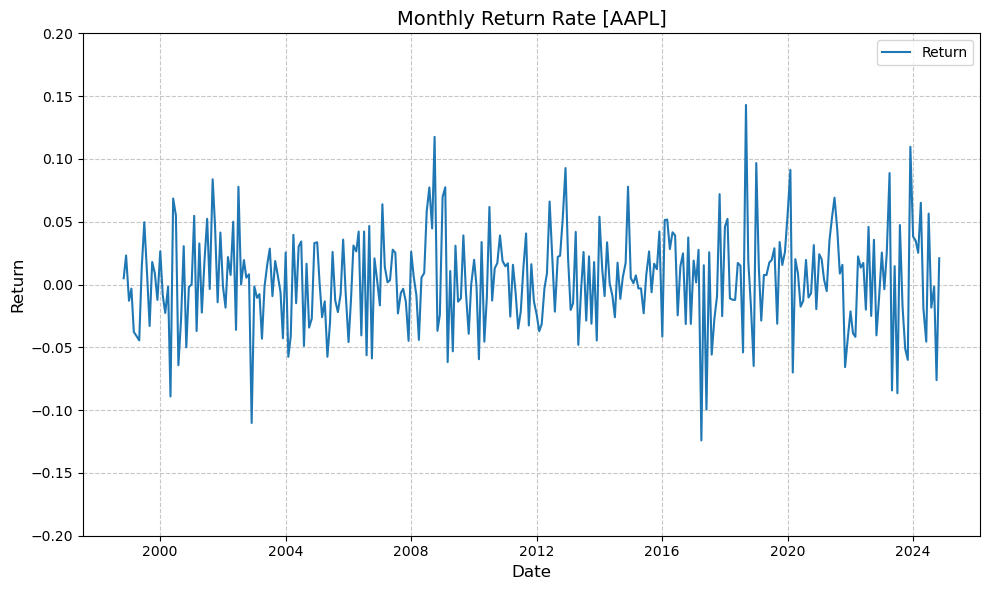

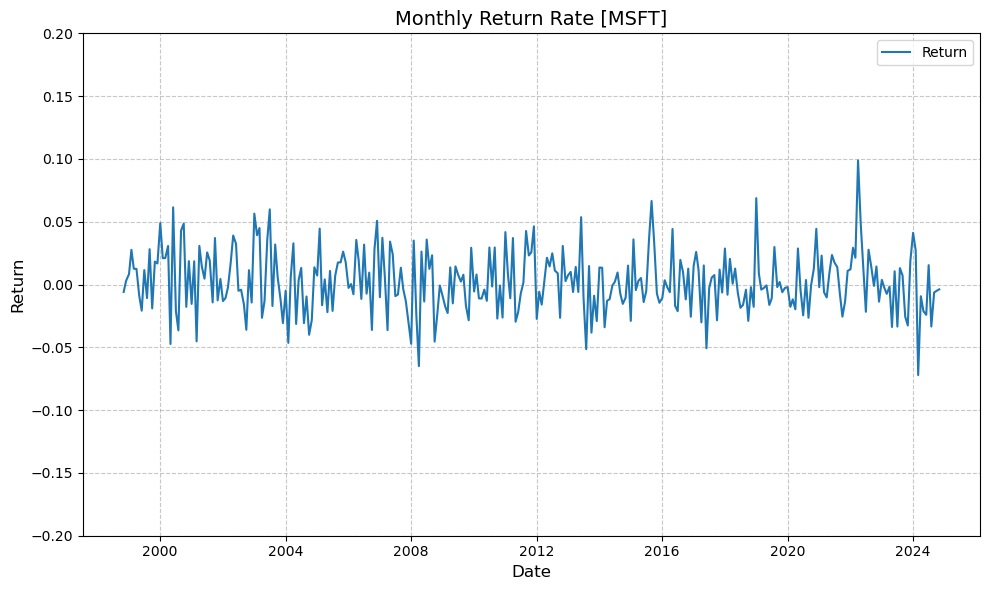

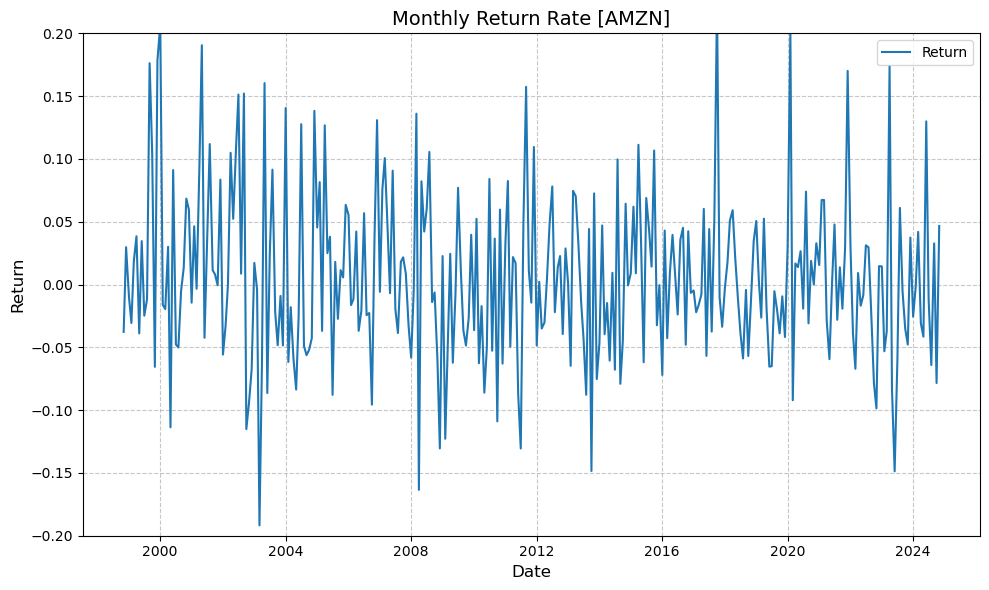

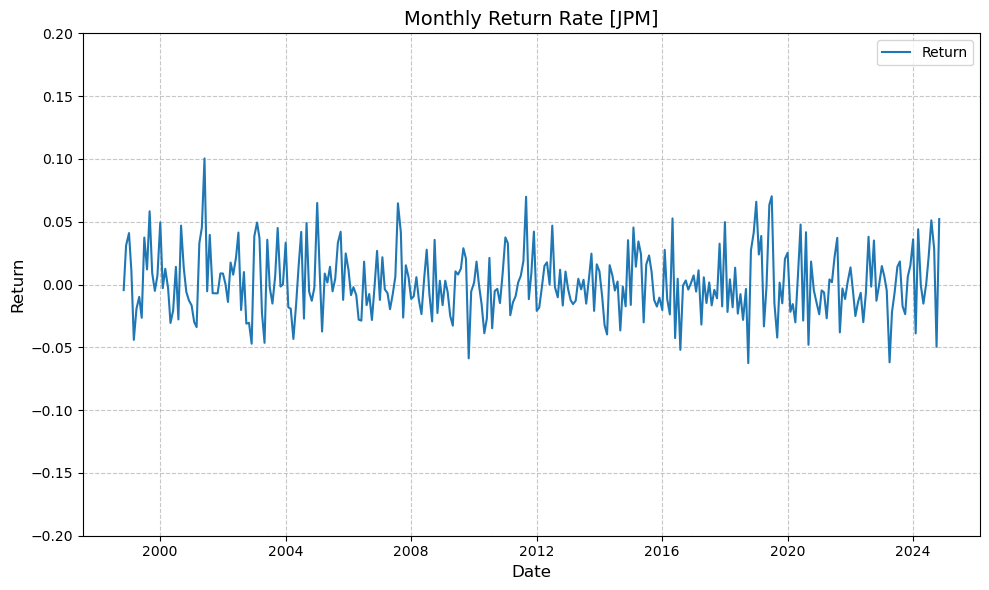

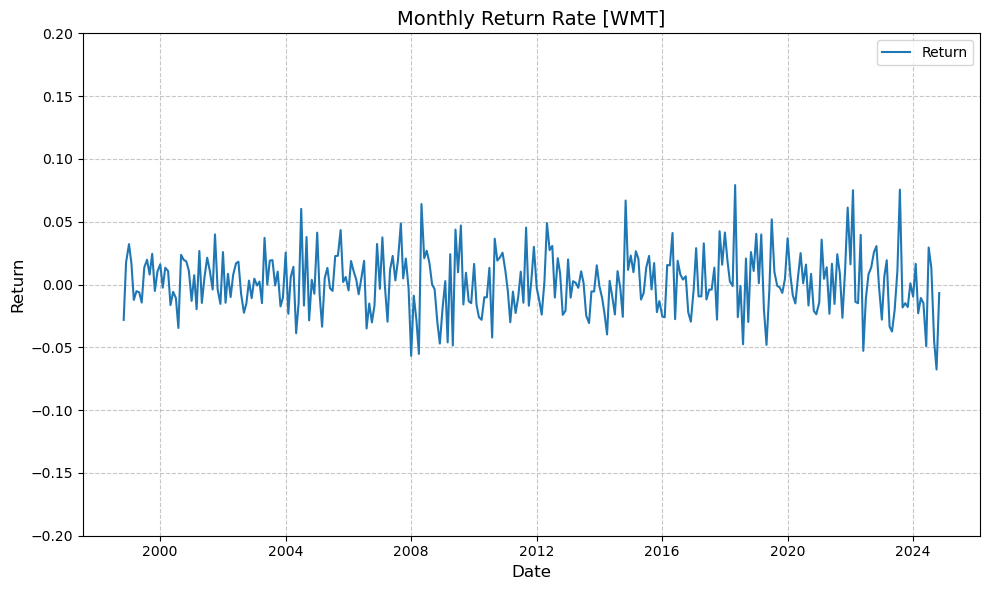

In [243]:
# Faccio il grafico di tutti i ritorni per ogni stock

for ticker, ret in monthly_ret_rates.items():
    plot_ret_rate(ret, "Monthly Return Rate [" + ticker + "]")

## Frontiera efficiente

### Matrice Varianza-Covarianza

In [244]:
# Unisco i dati delle varie stock in un unico dataframe
all_stocks = pd.DataFrame()
for ticker, stock in stocks.items():
    df = pd.DataFrame()
    df = stock.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    df = df.rename(columns={"Adj Close": ticker})
    
    all_stocks = pd.concat([all_stocks, df[ticker]], axis=1)

all_stocks.dropna(inplace=True)
print(all_stocks.cov())

all_stocks_weekly = all_stocks.copy()
all_stocks_weekly.dropna(inplace=True)
all_stocks_weekly["Date"] = all_stocks_weekly.index.astype(str)
all_stocks_weekly["Date"] = pd.to_datetime(all_stocks_weekly["Date"])
all_stocks_weekly["Date"] = all_stocks_weekly["Date"].dt.tz_localize(None)
all_stocks_weekly["Week"] = all_stocks_weekly["Date"].dt.to_period("W")
all_stocks_weekly = all_stocks_weekly.groupby("Week").first().reset_index()
all_stocks_weekly.set_index("Date", inplace=True)
all_stocks_weekly.drop(columns=["Week"], inplace=True)

all_stocks_monthly = all_stocks.copy()
all_stocks_monthly.dropna(inplace=True)
all_stocks_monthly["Date"] = all_stocks_monthly.index.astype(str)
all_stocks_monthly["Date"] = pd.to_datetime(all_stocks_monthly["Date"])
all_stocks_monthly["Date"] = all_stocks_monthly["Date"].dt.tz_localize(None)
all_stocks_monthly["Month"] = all_stocks_monthly["Date"].dt.to_period("M")
all_stocks_monthly = all_stocks_monthly.groupby("Month").first().reset_index()
all_stocks_monthly.set_index("Date", inplace=True)
all_stocks_monthly.drop(columns=["Month"], inplace=True)

# Costruisco la matrice di covarianza
print(all_stocks_weekly.cov())
print(all_stocks_monthly.cov())

             AAPL          MSFT         AMZN          JPM          WMT
AAPL  3375.273597   6173.275003  3084.820192  2601.179677   837.294384
MSFT  6173.275003  11557.031499  5751.439605  4854.766957  1543.510983
AMZN  3084.820192   5751.439605  3192.273139  2541.503431   800.968271
JPM   2601.179677   4854.766957  2541.503431  2216.075472   680.436884
WMT    837.294384   1543.510983   800.968271   680.436884   221.397369
             AAPL          MSFT         AMZN          JPM          WMT
AAPL  3369.819177   6162.926347  3077.603455  2598.454615   835.993066
MSFT  6162.926347  11539.288869  5737.997206  4850.090236  1541.101677
AMZN  3077.603455   5737.997206  3181.536721  2537.159224   798.931786
JPM   2598.454615   4850.090236  2537.159224  2215.132516   679.938414
WMT    835.993066   1541.101677   798.931786   679.938414   221.018654
             AAPL          MSFT         AMZN          JPM          WMT
AAPL  3360.882238   6142.010544  3072.040822  2574.772028   831.401866
MSFT  

### Tassi di rendimento per le stock

In [ ]:
# Calcolo del tasso di rendimento per ogni stock
stock_exp_daily_return = pd.DataFrame()
stock_exp_weekly_return = pd.DataFrame()
stock_exp_monthly_return = pd.DataFrame()

# Calcolo il tasso di rendimento medio
stock_exp_daily_return["Return"] = (np.log(all_stocks.iloc[-1]) - np.log(all_stocks.iloc[0])) / len(all_stocks)
stock_exp_weekly_return["Return"] = weekly_ret_rates.mean()
stock_exp_monthly_return["Return"] = monthly_ret_rates.mean()

print(stock_exp_daily_return)
print(stock_exp_weekly_return)
print(stock_exp_monthly_return)

        Return
AAPL  0.001021
MSFT  0.000494
AMZN  0.000797
JPM   0.000397
WMT   0.000377
        Return
AAPL  0.001047
MSFT  0.000319
AMZN  0.002098
JPM   0.000592
WMT   0.000667
        Return
AAPL  0.003986
MSFT  0.002263
AMZN  0.005626
JPM   0.001562
WMT   0.001791


### Insieme dei portafogli fattibili

In [251]:
# Creo un dataframe in cui faccio variare la combinazione dei pesi delle azioni
wallets = pd.DataFrame()
# creo una colonna per ogni peso
for ticker in tickers:
    # faccio 100 estrazioni casuali tra 0 e 1
    wallets[ticker] = np.random.uniform(-10000, 10000, 100000)
    #wallets[ticker] = np.random.normal(0, 1000, 100000)

# Normalizzo i pesi
wallets = wallets.div(wallets.sum(axis=1), axis=0)

# Calcolo il rendimento atteso pesando i rendimenti delle azioni per i pesi
wallets_daily_return = (wallets * stock_exp_daily_return["Return"]).sum(axis=1)
wallets_weekly_return = (wallets * stock_exp_weekly_return["Return"]).sum(axis=1)
wallets_monthly_return = (wallets * stock_exp_monthly_return["Return"]).sum(axis=1)

# Calcolo la varianza pesata
cov = all_stocks.cov()
print(cov)
wallets_daily_variance = wallets.apply(lambda x: np.sqrt(np.dot(x, np.dot(cov, x))), axis=1)
wallets_weekly_variance = wallets.apply(lambda x: np.sqrt(np.dot(x, np.dot(cov, x))), axis=1)
wallets_monthly_variance = wallets.apply(lambda x: np.sqrt(np.dot(x, np.dot(cov, x))), axis=1)


# Unisco i dati in un unico dataframe
wallets["Daily_Return"] = wallets_daily_return
wallets["Weekly_Return"] = wallets_weekly_return
wallets["Monthly_Return"] = wallets_monthly_return
wallets["Risk"] = wallets_daily_variance
print(wallets.head)


             AAPL          MSFT         AMZN          JPM          WMT
AAPL  3375.273597   6173.275003  3084.820192  2601.179677   837.294384
MSFT  6173.275003  11557.031499  5751.439605  4854.766957  1543.510983
AMZN  3084.820192   5751.439605  3192.273139  2541.503431   800.968271
JPM   2601.179677   4854.766957  2541.503431  2216.075472   680.436884
WMT    837.294384   1543.510983   800.968271   680.436884   221.397369
<bound method NDFrame.head of            AAPL      MSFT      AMZN       JPM       WMT  Daily_Return  \
0     -0.328125  0.641191  1.167176 -0.799422  0.319180      0.000715   
1      0.300446  0.435555  0.373556 -0.444511  0.334954      0.000769   
2     -0.499947  6.052846 -6.581035 -1.884903  3.913039     -0.002039   
3     -3.239619  3.450345 -0.069109 -3.110365  3.968748     -0.001398   
4     -1.115401  0.561332  0.455815  0.375704  0.722550     -0.000077   
...         ...       ...       ...       ...       ...           ...   
99995 -0.550947 -0.115473  0.5370

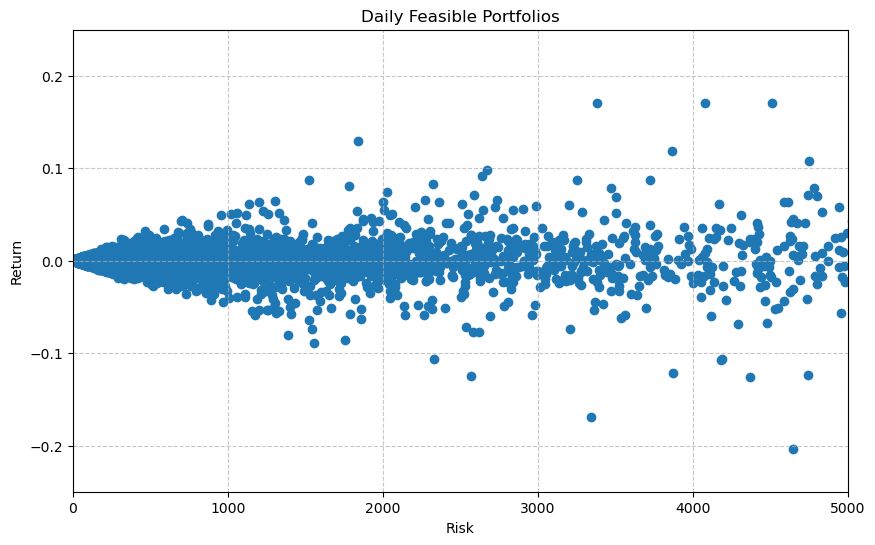

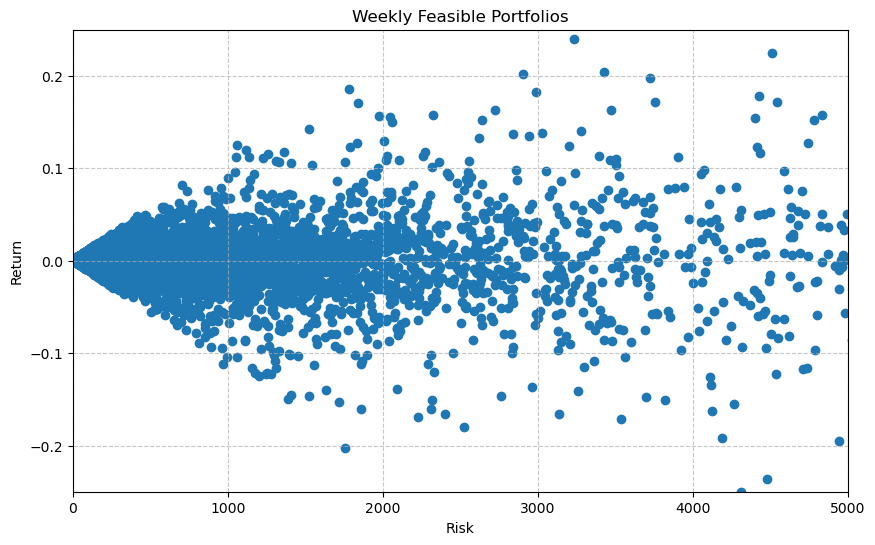

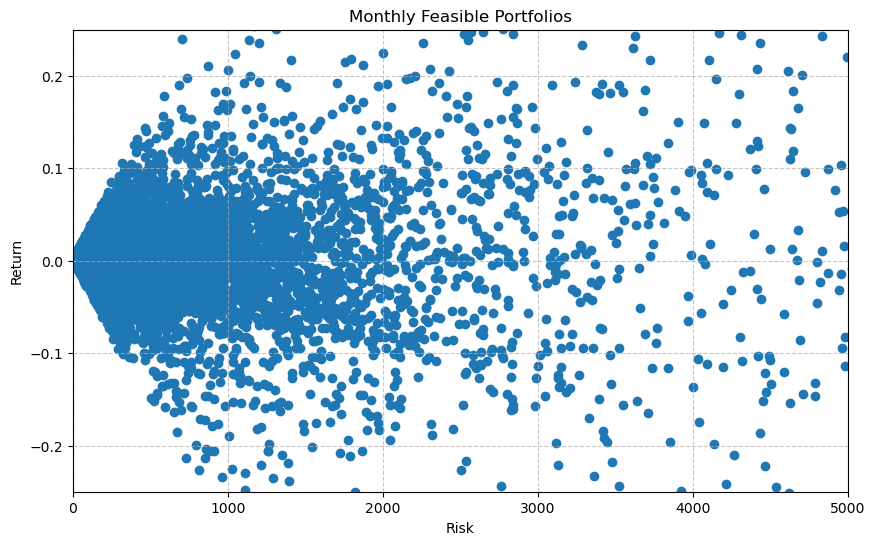

In [252]:
# Grafico i vari portafogli con uno scatter plot
def plot_feasible_wallets(risk, exp_ret, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(risk, exp_ret, alpha=1)
    plt.title(title)
    plt.xlabel("Risk")
    plt.ylabel("Return")
    plt.xlim(0, 0.5e4)
    plt.ylim(-0.25, 0.25)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_feasible_wallets(wallets["Risk"], wallets["Daily_Return"] , "Daily Feasible Portfolios")
plot_feasible_wallets(wallets["Risk"], wallets["Weekly_Return"] , "Weekly Feasible Portfolios")
plot_feasible_wallets(wallets["Risk"], wallets["Monthly_Return"] , "Monthly Feasible Portfolios")

## Autocorrelation


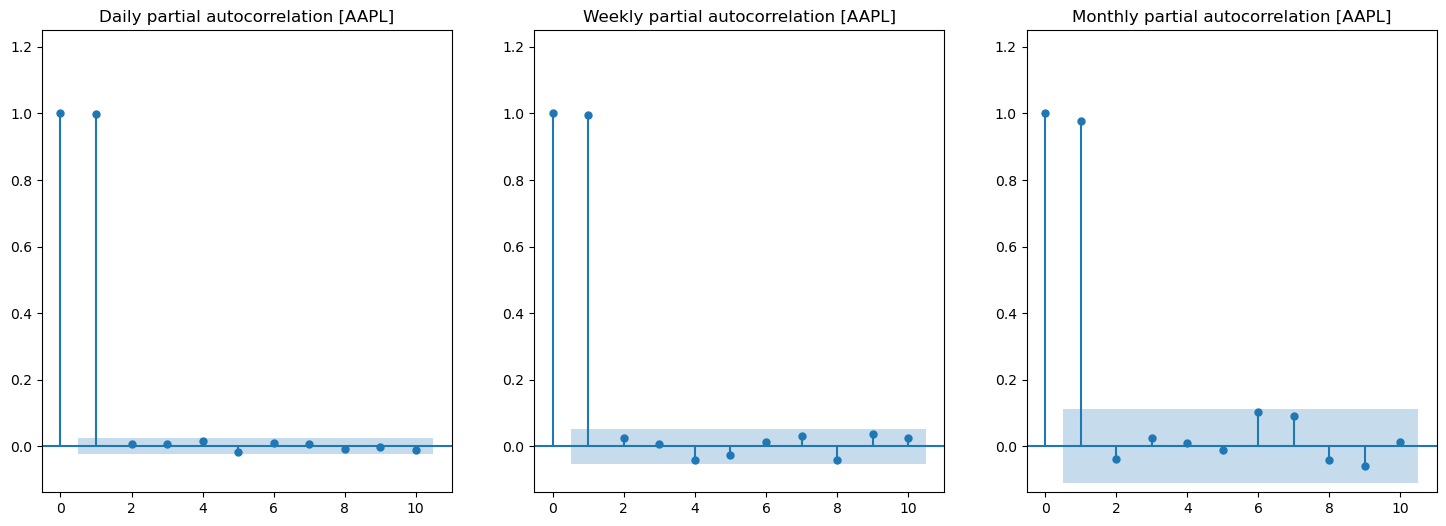

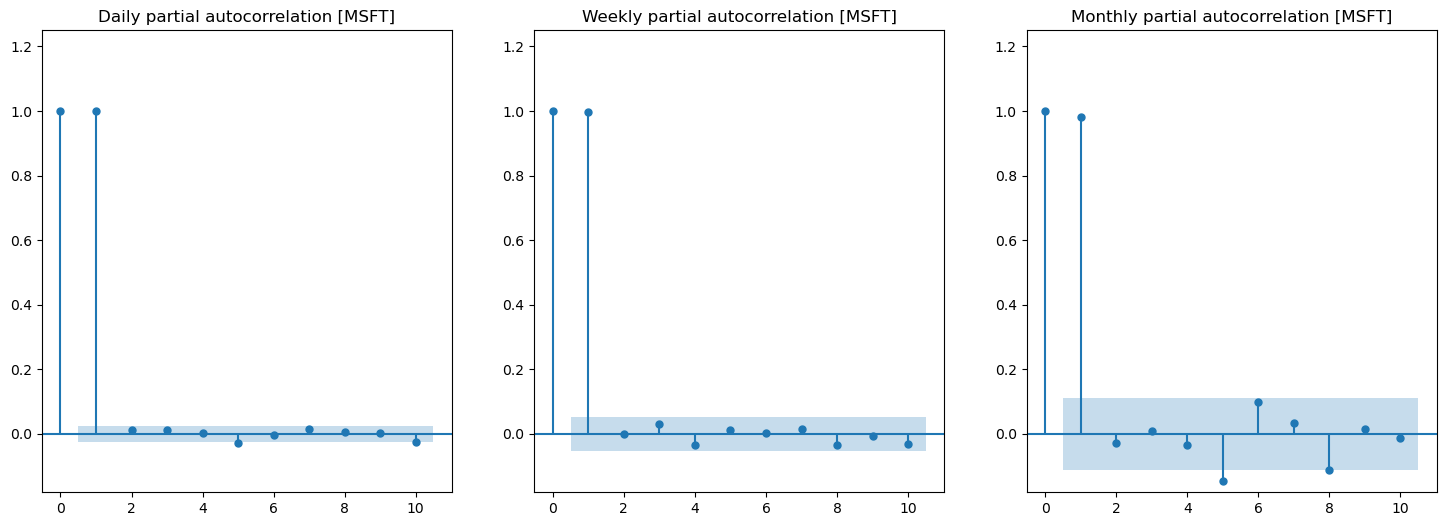

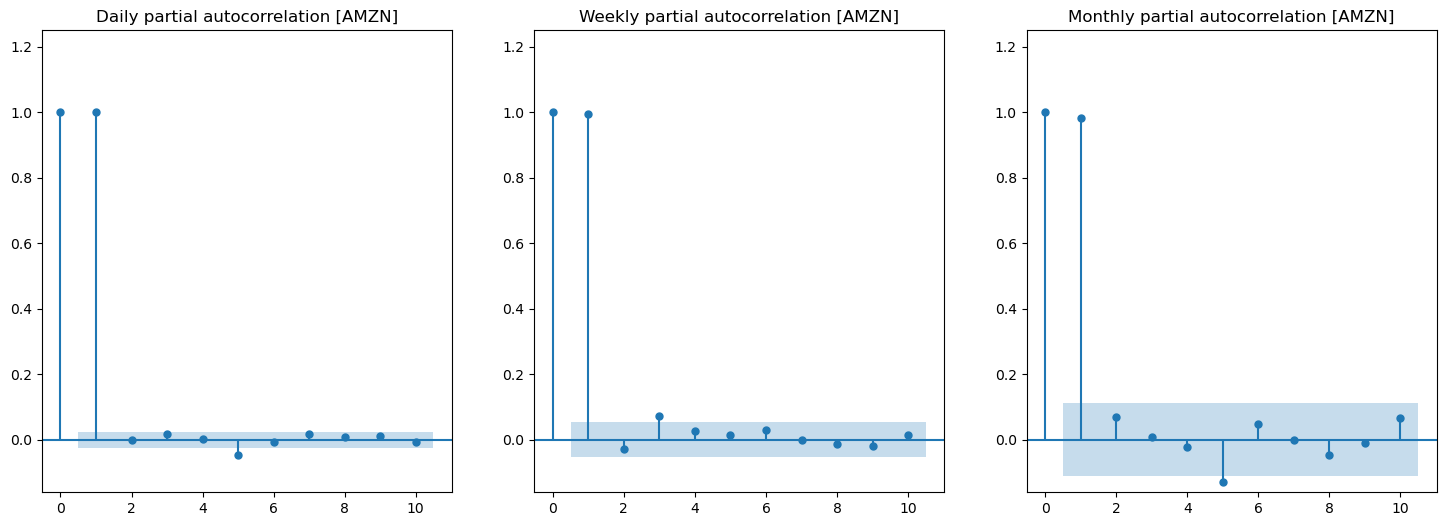

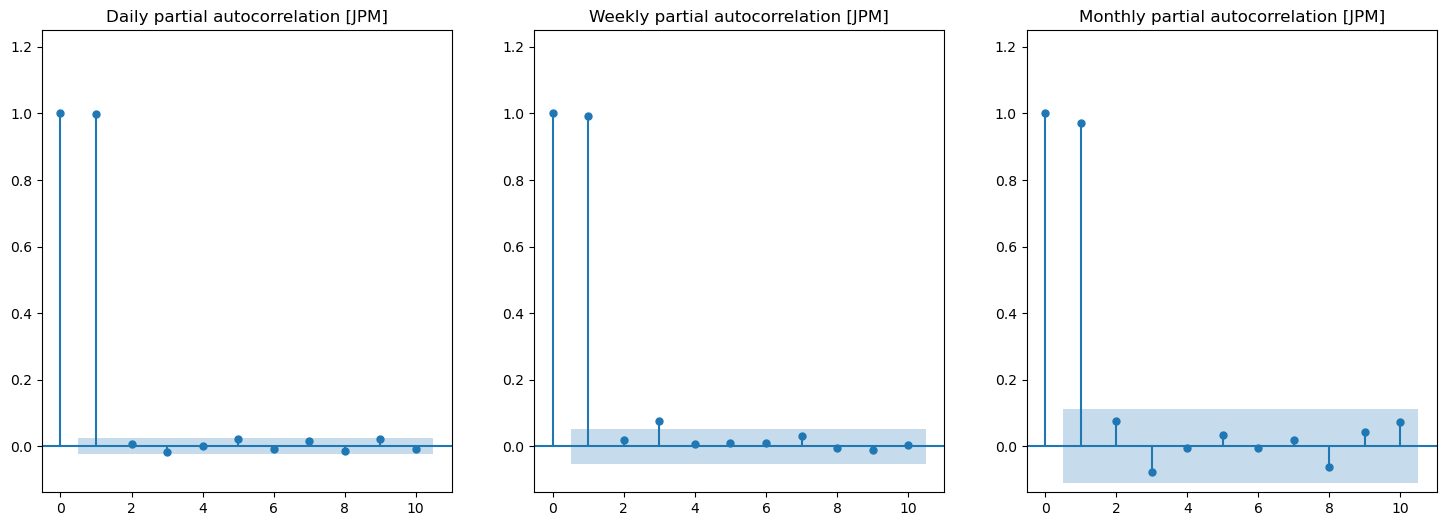

In [248]:
from statsmodels.graphics.tsaplots import plot_pacf

# Calcolo l'autocorrelazione dei rendimenti
for ticker in tickers:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plot_pacf(all_stocks[ticker], lags=10, title="Daily partial autocorrelation [" + ticker + "]", auto_ylims=True, zero=True, ax=axes[0])
    plot_pacf(all_stocks_weekly[ticker], lags=10, title="Weekly partial autocorrelation [" + ticker + "]", auto_ylims=True, zero=True, ax=axes[1])
    plot_pacf(all_stocks_monthly[ticker], lags=10, title="Monthly partial autocorrelation [" + ticker + "]", auto_ylims=True, zero=True, ax=axes[2])
    max_y = max(max(ax.get_ylim()) for ax in axes)  
    min_y = min(min(ax.get_ylim()) for ax in axes)
    for ax in axes:
        ax.set_ylim(min_y, max_y)
    
plt.close()